In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from IPython.display import clear_output
import albumentations as A

from dataset import *
from config import *
from utils import *
from models.model import UNet

In [6]:
model = UNet(3, 1, init_features=32)
model.load_state_dict(torch.load('saved/models/model_1'))
model.to(DEVICE)
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

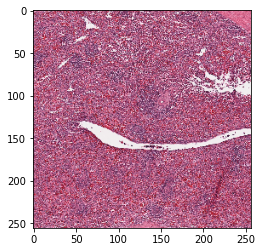

In [7]:
from utils import get_transforms, threshold_tensor, get_mask_highlight
means = np.array([212.1089, 205.7680, 210.4203]) / 255
stds = np.array([41.9276, 48.7806, 45.6515]) / 255
transform, test_transform, inv_normalize = get_transforms(means, stds, IMG_SIZE)

test_path = os.path.join("data/test_images/"+ '10078.tiff')
submission_img = plt.imread(test_path)

image = test_transform(image=submission_img)['image'].to(DEVICE).unsqueeze(0)
out = model(image).squeeze(1)
plt_img = inv_normalize(image=image[0].permute(1, 2, 0).cpu().numpy())['image']
plt_out = threshold_tensor(out).detach().cpu().numpy().astype(np.uint8)[0]
plt_mask = get_mask_highlight(plt_img, plt_out)

plt_img[plt_out == 1] = 1

plt.imshow(plt_img)

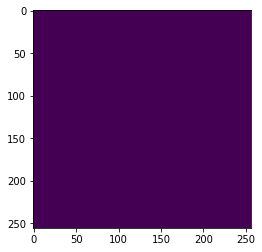

In [10]:
plt.imshow(plt_out)

In [15]:
train_loader, train_writer, \
        val_loader, val_writer, \
        test_loader, test_writer, \
        submission_writer       =   prepare(transform, test_transform, "saved/tensorboard/runs_1")


In [32]:
for i, data in enumerate(val_loader):
    image, mask = data['image'].to(DEVICE), data['mask'].to(DEVICE)
    out = model(image).squeeze(1)
    break


In [33]:
plt_imgs, plt_outs, plt_masks = format_tensors_plt(image, out, inv_normalize, mask=mask)


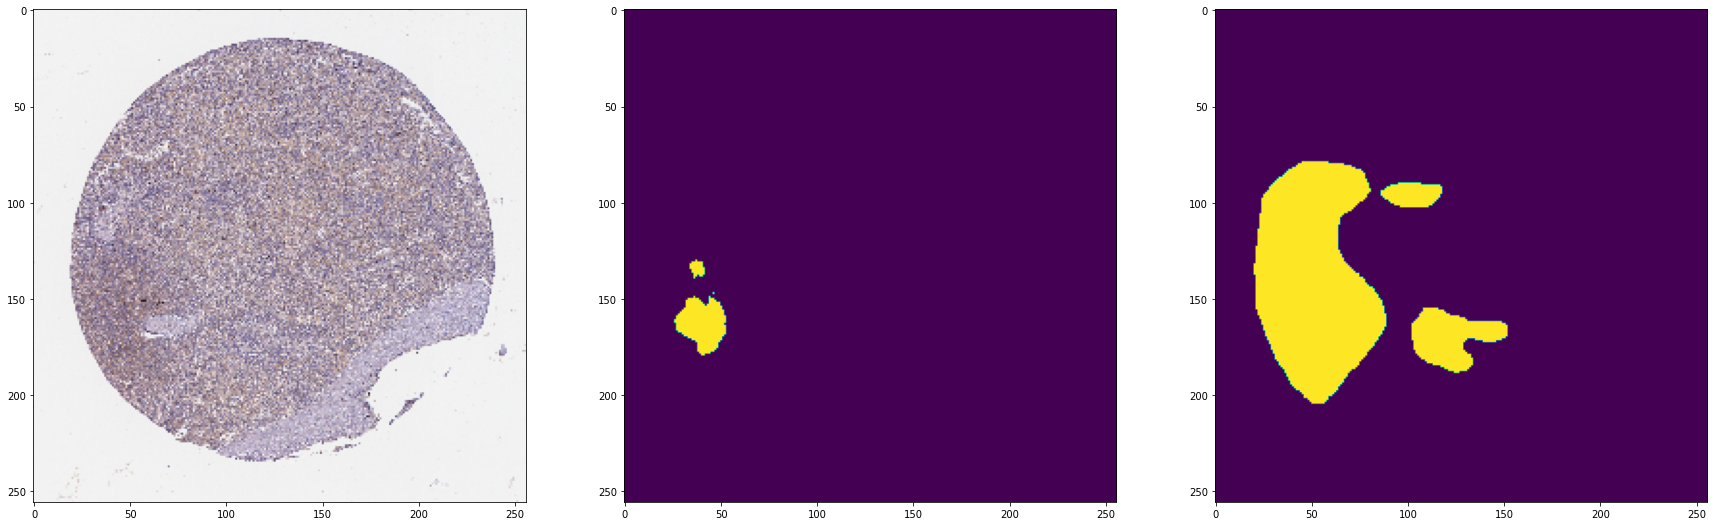

In [37]:
i = 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].imshow(plt_imgs[i])
axs[1].imshow(plt_outs[i])
axs[2].imshow(plt_masks[i])

In [2]:
'''
id: 10044
organ: prostate
data_source: HPA
img_hegith: 3000
img_width: 3000
pixel_size: 0.4
    All HPA = 0.4
    HuBMAP:
        kidney = 0.5 um
        large intestine = 0.2290
        lung = 0.7562
        spleen = 0.4945
        prostate = 6.263
tissue_thickness: 4
    All HPA = 4
    HuBMAP 
        10 µm for kidney
        8 µm for large intestine
        4 µm for spleen
        5 µm for lung
        5 µm for prostate.
rle: 3842
age: 37.0
sex: Male
'''

'\nid: 10044\norgan: prostate\ndata_source: HPA\nimg_hegith: 3000\nimg_width: 3000\npixel_size: 0.4\n    All HPA = 0.4\n    HuBMAP:\n        kidney = 0.5 um\n        large intestine = 0.2290\n        lung = 0.7562\n        spleen = 0.4945\n        prostate = 6.263\ntissue_thickness: 4\n    All HPA = 4\n    HuBMAP \n        10 µm for kidney\n        8 µm for large intestine\n        4 µm for spleen\n        5 µm for lung\n        5 µm for prostate.\nrle: 3842\nage: 37.0\nsex: Male\n'

In [3]:
train_csv = pd.read_csv('data/train.csv')
train_csv.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [4]:
train_csv.describe()

,id,img_height,img_width,pixel_size,tissue_thickness,age
count,351.000000,351.000000,351.000000,3.510000e+02,351.0,351.000000
mean,16662.914530,2978.364672,2978.364672,4.000000e-01,4.0,60.364672
std,9863.945557,90.962085,90.962085,1.111808e-16,0.0,16.013327
min,62.000000,2308.000000,2308.000000,4.000000e-01,4.0,21.000000
25%,8229.000000,3000.000000,3000.000000,4.000000e-01,4.0,55.000000
50%,16609.000000,3000.000000,3000.000000,4.000000e-01,4.0,60.000000
75%,25630.500000,3000.000000,3000.000000,4.000000e-01,4.0,73.000000
max,32741.000000,3070.000000,3070.000000,4.000000e-01,4.0,84.000000


<AxesSubplot:xlabel='organ'>

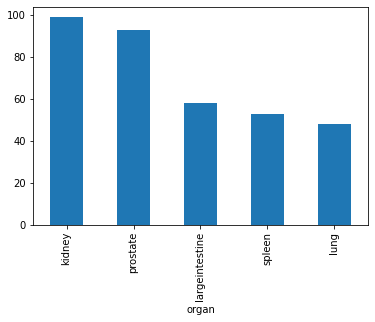

In [5]:
train_csv.value_counts('organ').plot(kind='bar')

Text(0.5, 1.0, 'histogram of age')

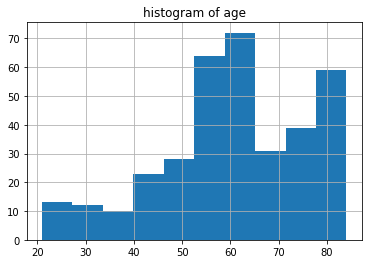

In [6]:
train_csv['age'].hist()
plt.title('histogram of age')

In [7]:
train_csv['sex'].value_counts()

Male      229
Female    122
Name: sex, dtype: int64

In [8]:
def rle2mask(mask_rle: str, label=1, shape=(3000, 3000)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape).T

def draw_mask_higlight(img, mask):
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(img, [c], -1, (255, 0, 0), thickness=10)

In [9]:
file = None
train_csv = pd.read_csv('data/train.csv')

def plot_mask(file):
    id = int(file.split('/')[-1][:-5])
    img = plt.imread(file)
    
    id_row = train_csv[train_csv['id'] == id]
    mask = rle2mask(id_row.rle.item())
    
    idx = (mask == 1)
    img_mask_highlight = img.copy()
    draw_mask_higlight(img_mask_highlight, mask)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_mask_highlight)
    plt.title(f'{id_row.id.item()}, {id_row.organ.item()}, {id_row.data_source.item()}, {id_row.age.item()}, {id_row.sex.item()}')
    plt.show()

In [10]:
def find_messed_up_data():
    train_images = os.listdir('data/train_images')
    messed_up = []

    for train_img in train_images:
        clear_output(wait=True)
        img_path = 'data/train_images/' + train_img
        plot_mask(img_path)
        val = input()
        if val =='x':
            messed_up.append(img_path)
    return messed_up

NameError: name 'train_csv' is not defined

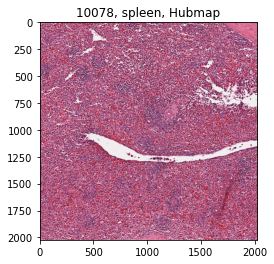

In [19]:
test_img = plt.imread('data/test_images/10078.tiff')
plt.imshow(test_img)
plt.title(f'10078, spleen, Hubmap')
'''
id,   organ, data_source,img_height,img_width,pixel_size,tissue_thickness
10078,spleen,Hubmap,     2023,      2023,     0.4945,    4
'''
train_spleens = train_csv[train_csv['organ'] == 'prostate']
for i in range(len(train_csv)):
    plot_mask('data/train_images/' + str(train_spleens.iloc[i].id.item()) + '.tiff')
    if i == 10:
        break

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from IPython.display import clear_output
import albumentations as A
import torch
from torch.utils.data import random_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from dataset import *
from train import *

Using cache found in /home/mkim/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [2]:
img = plt.imread('data/train_images/10044.tiff')
test_img = plt.imread('data/test_images/10078.tiff')

In [3]:
csv_file = 'data/train.csv'
root_dir = 'data/train_images'

BATCH_SIZE= 8

# TODO: Fix transformation. Get cropped and rotated mirroring.
resize = A.augmentations.geometric.resize.Resize(256, 256)

normalize = A.augmentations.transforms.Normalize(mean=(0.86866415, 0.85054709, 0.87718028), 
                                                 std=(0.1358818 , 0.15704154, 0.12908407))
transform = {'resize': resize, 'normalize':normalize}
inv_normalize = A.Compose([
    A.augmentations.transforms.Normalize(mean = (0., 0., 0.), std=(1/0.1358818, 1/0.15704154, 1/0.12908407), max_pixel_value=1),
    A.augmentations.transforms.Normalize(mean = (-0.86866415, -0.85054709, -0.87718028), std = (1.0, 1.0, 1.0), max_pixel_value=1),
])

# TODO: Stratified Sampling for balanced label
full_dataset = HPADataset(csv_file, root_dir, transform=None)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 325 Training Data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# train_writer = SummaryWriter()

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)
# val_writer = SummaryWriter()

# 26 Test Data
test_dataset = HPADataset(csv_file, root_dir, transform=transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)
# test_writer = SummaryWriter()

In [14]:
normalize = A.augmentations.transforms.Normalize(mean=np.array([0.86866415, 0.85054709, 0.87718028]), 
                                                std=(0.1358818 , 0.15704154, 0.12908407))
normalize(image=img)['image'].shape

(3000, 3000, 3)

In [6]:
model.to('cpu')
with torch.no_grad():
    for i, data in enumerate(train_loader):
        image, mask = data['image'], data['mask']
        out = model(image).detach().cpu()

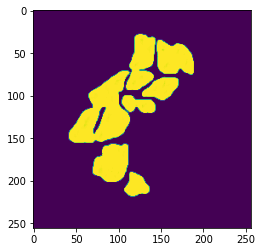

In [7]:
plt.imshow(out.numpy()[0][0])

In [19]:
test_sample = dataset.get_test_image(test_img)['image'].unsqueeze(0)
test_out = model(test_sample).detach().cpu().numpy()[0][0]
test_out.shape

(256, 256)

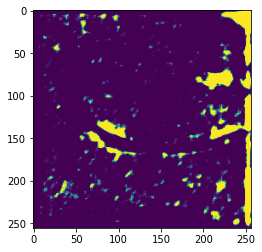

In [20]:
plt.imshow(test_out)

In [8]:
# plt.imshow(threshold(out))
dataset.get_dice(mask, dataset.threshold(out[0]))

0.02275235578417778

In [6]:
img = plt.imread('data/train_images/10044.tiff')
full_dataset.get_mask_highlight(img)

TypeError: HPADataset.get_mask_highlight() missing 1 required positional argument: 'mask'